# Enable GPU

We are compiling this model on google colab using GPU

In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
with tf.device(device_name):
  print(device_name.split(':')[1], " running...")

GPU  running...


# Ignore warnings of layers in model during training

In [5]:
import warnings
warnings.filterwarnings("ignore")

# Import Libraries

In [6]:
import os, keras, numpy
import matplotlib.pyplot as plt
from numpy import *
from numpy.random import *
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras.models import *
from keras.layers import *

# Define "Discriminator" Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3137      
Total params: 40,705
Trainable params: 40,705
Non-trainable params: 0
____________________________________________________

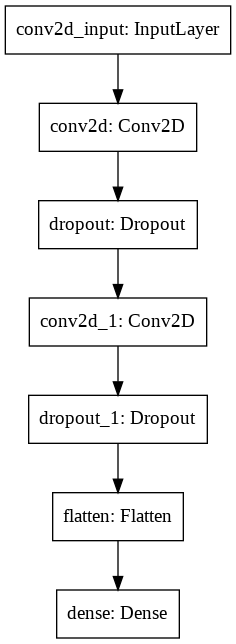

In [7]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', activation='relu', input_shape=in_shape))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3,3), strides=(2, 2), activation='relu', padding='same'))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
a = define_discriminator()
print(a.summary())
print("\n\n")
tf.keras.utils.plot_model(a)

# Define "Generator" Model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       65664     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       65664     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         513       
Total params: 765,313
Trainable params: 765,313
Non-trainable params: 0
_________________________________________________________________
None





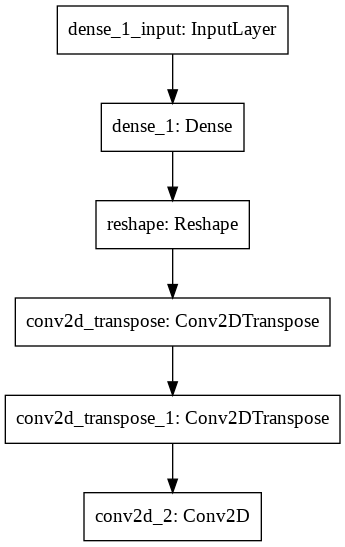

In [8]:
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, activation = 'relu', input_dim=latent_dim))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (2,2), strides=(2,2), activation = 'relu', padding='same'))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (2,2), strides=(2,2), activation = 'relu', padding='same'))
	model.add(Conv2D(1, (2,2), activation='tanh', padding='same'))
	return model
b = define_generator(100)
print(b.summary())
print("\n\n")
tf.keras.utils.plot_model(b)

# Define "GAN" Model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_input (InputLayer)   [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       65664     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       65664     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         513       
_________________________________________________________________
sequential (Sequential)      (None, 1)                 40705 

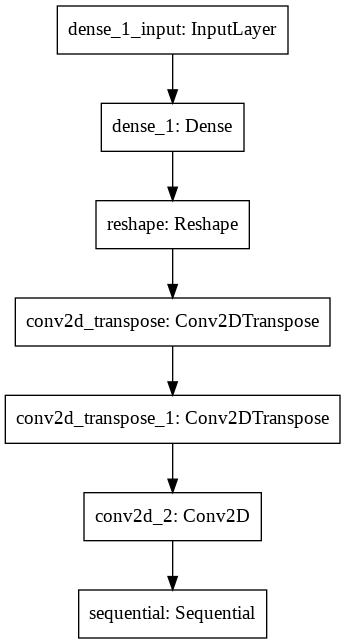

In [9]:
def define_gan(g_model, d_model):

  d_model.trainable = False

  g_input = g_model.input
  g_output = g_model.output

  d_output = d_model(g_output)

  model = Model(g_input, d_output)

  opt = Adam(learning_rate= 3e-4, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt,  metrics=['accuracy'])
  
  return model
c = define_gan(b, a)
print(c.summary())
print("\n\n")
tf.keras.utils.plot_model(c)

# Load Dataset

In [17]:
def load_real_samples():
  (trainX, trainy), (_, _) = mnist.load_data()
  # expand to 3d, e.g. add channels
  X = expand_dims(trainX, axis=-1)
  X = X.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X

# Plot Data

In [18]:
def save_plot(x_input,n=4):
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.imshow(x_input[i,:,:,0], cmap = 'gray_r')
        plt.axis('off')
    plt.show()


# Generate Real data in batch

In [19]:
def generate_real_samples(dataset, n_samples):
	images = dataset
	ix = randint(0, images.shape[0], n_samples)
	X = images[ix]
	y = ones((n_samples, 1))
	return X, y


# Generate Fake data in batch

In [20]:
def generate_latent_points(latent_dim, n_samples):
  x_input = randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  return z_input

def generate_fake_samples(generator, latent_dim, n_samples):
	z_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict(z_input)
	y = zeros((n_samples, 1))
	return images, y


# Summarize The Model

In [21]:

def summarize_the_model(generator, latent_dim = 100):
    latent_points = generate_latent_points(latent_dim= 100, n_samples= 16)
    X  = generator.predict(latent_points)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    save_plot(X, n=4)

# Train The Model

In [24]:
def train(g_model, d_model, gan_model, dataset, latent_dim= 100, n_epochs=3, n_batch=128):

  bat_per_epo = int(dataset.shape[0] / n_batch)
  print("batch per epoch: ", bat_per_epo)
  half_batch = int(n_batch / 2)
  print("half batch: ", half_batch)
  print("***********\n\n\n")

  for i in range(n_epochs):
    d_loss_r,d_loss_f = 0.0,0.0
    g_loss = 0.0
    
    for j in range(bat_per_epo):

      X_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      d_loss_r += d_loss1

      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      d_loss_f += d_loss2

      z_input = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss1,_ = gan_model.train_on_batch(z_input, y_gan)
      g_loss += g_loss1
    print('epoch -> [%d/%d], d_loss_real = %.4f, d_loss_fake = %.4f, g_loss = %.4f' %(i+1, n_epochs, d_loss_r, d_loss_f, g_loss))
    summarize_the_model(g_model)
    if i == 0:
      # set the model PATH according to your system
      g_model.save("generator_mnist.h5")
    # set the model PATH according to your system
    os.remove("generator_mnist.h5")
    g_model.save("generator_mnist.h5")

#Main Function

Attach models to the GPU


READY TO GO !!!


batch per epoch:  468
half batch:  64
***********



epoch -> [1/30], d_loss_real = 274.6324, d_loss_fake = 334.1566, g_loss = 373.1782


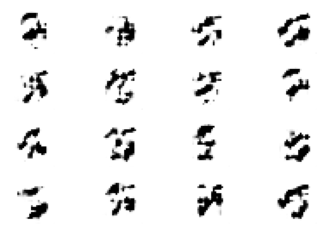

epoch -> [2/30], d_loss_real = 333.6521, d_loss_fake = 325.2934, g_loss = 342.1096


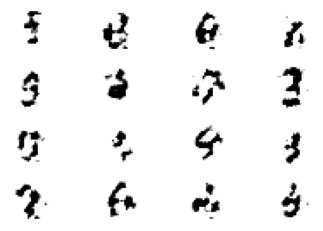

epoch -> [3/30], d_loss_real = 321.2403, d_loss_fake = 322.7322, g_loss = 338.4314


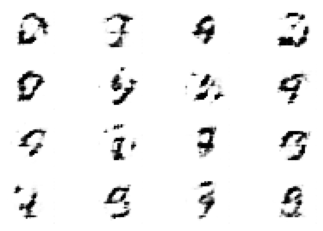

epoch -> [4/30], d_loss_real = 316.8174, d_loss_fake = 320.0353, g_loss = 341.9562


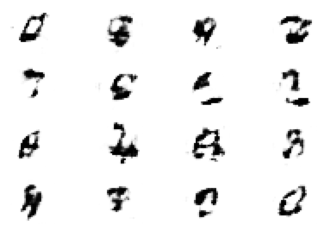

epoch -> [5/30], d_loss_real = 317.7788, d_loss_fake = 321.1159, g_loss = 340.9901


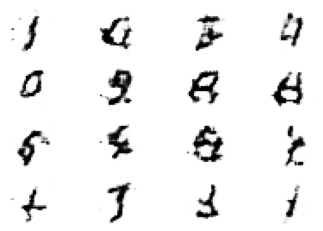

epoch -> [6/30], d_loss_real = 320.9388, d_loss_fake = 324.1371, g_loss = 336.7844


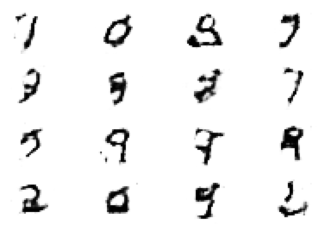

epoch -> [7/30], d_loss_real = 322.9225, d_loss_fake = 325.7939, g_loss = 333.1110


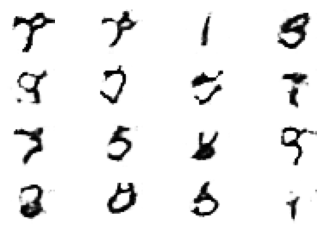

epoch -> [8/30], d_loss_real = 323.6604, d_loss_fake = 325.8418, g_loss = 331.9591


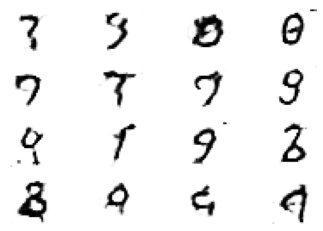

epoch -> [9/30], d_loss_real = 324.3826, d_loss_fake = 325.6259, g_loss = 331.2285


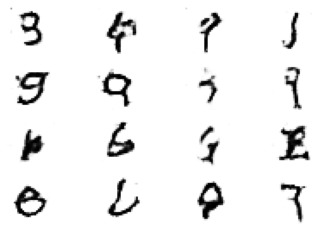

epoch -> [10/30], d_loss_real = 324.6905, d_loss_fake = 325.3665, g_loss = 330.3937


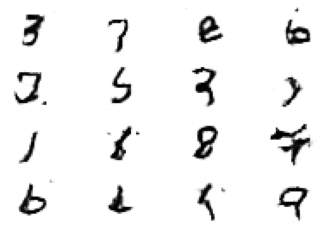

epoch -> [11/30], d_loss_real = 324.2877, d_loss_fake = 324.9006, g_loss = 330.0588


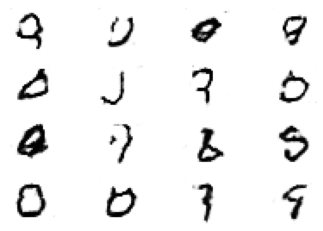

epoch -> [12/30], d_loss_real = 324.0625, d_loss_fake = 324.5717, g_loss = 330.1596


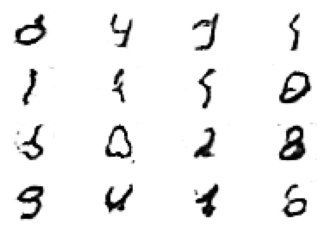

epoch -> [13/30], d_loss_real = 324.1921, d_loss_fake = 324.4890, g_loss = 329.9657


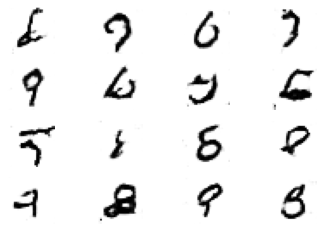

epoch -> [14/30], d_loss_real = 324.1010, d_loss_fake = 324.0745, g_loss = 329.9581


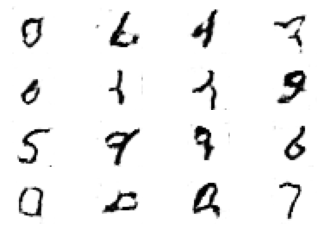

epoch -> [15/30], d_loss_real = 324.1707, d_loss_fake = 323.6685, g_loss = 330.0138


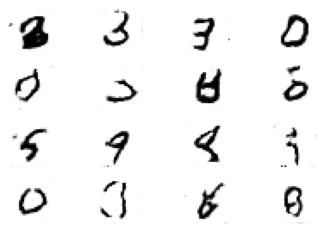

epoch -> [16/30], d_loss_real = 324.1702, d_loss_fake = 323.4056, g_loss = 330.1489


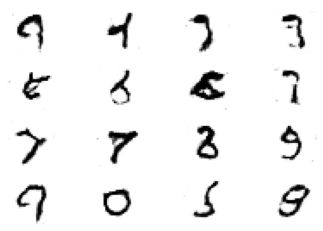

epoch -> [17/30], d_loss_real = 323.6551, d_loss_fake = 323.9235, g_loss = 329.5203


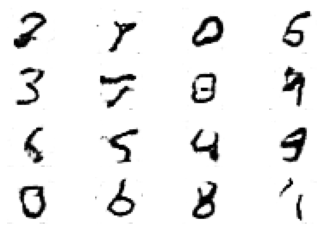

epoch -> [18/30], d_loss_real = 323.6237, d_loss_fake = 323.6636, g_loss = 329.7098


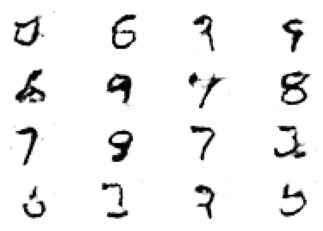

epoch -> [19/30], d_loss_real = 323.5462, d_loss_fake = 323.4749, g_loss = 329.3653


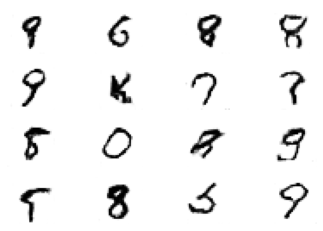

epoch -> [20/30], d_loss_real = 323.5384, d_loss_fake = 323.5733, g_loss = 329.4071


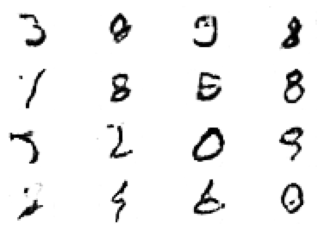

epoch -> [21/30], d_loss_real = 323.3260, d_loss_fake = 323.5778, g_loss = 329.5879


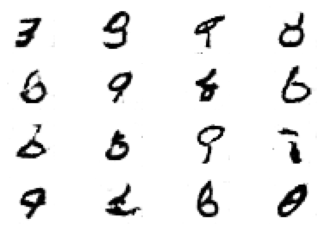

epoch -> [22/30], d_loss_real = 323.2004, d_loss_fake = 323.6911, g_loss = 329.1747


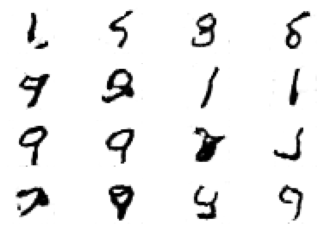

epoch -> [23/30], d_loss_real = 323.4773, d_loss_fake = 323.3863, g_loss = 329.6581


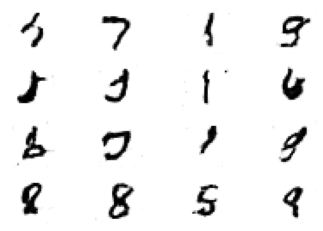

epoch -> [24/30], d_loss_real = 323.0394, d_loss_fake = 323.8181, g_loss = 329.0604


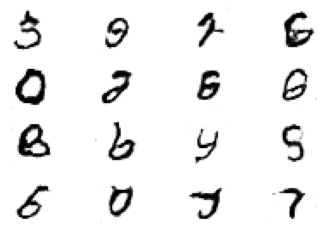

epoch -> [25/30], d_loss_real = 322.6085, d_loss_fake = 323.8837, g_loss = 328.7934


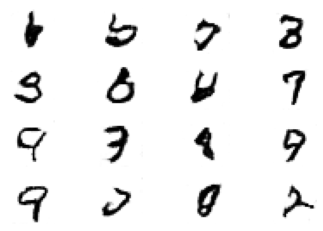

epoch -> [26/30], d_loss_real = 323.1878, d_loss_fake = 323.3985, g_loss = 329.2917


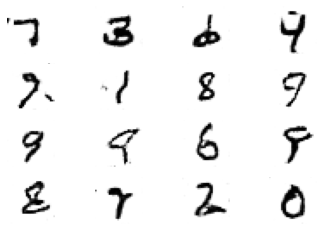

epoch -> [27/30], d_loss_real = 322.6508, d_loss_fake = 323.7032, g_loss = 329.1202


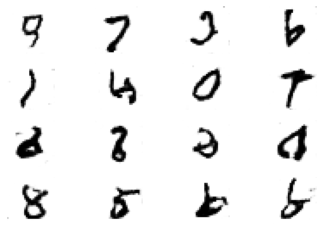

epoch -> [28/30], d_loss_real = 323.0097, d_loss_fake = 323.5015, g_loss = 329.2727


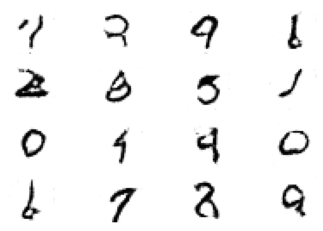

epoch -> [29/30], d_loss_real = 323.2360, d_loss_fake = 323.1106, g_loss = 329.8790


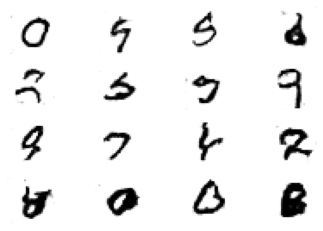

epoch -> [30/30], d_loss_real = 322.5321, d_loss_fake = 323.7870, g_loss = 329.3002


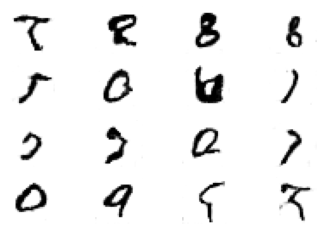

In [26]:
# ignore all the warnings
with tf.device(device_name):
  warnings.filterwarnings("ignore")

  latent_dim = 100
  n_epochs = 30
  n_batch = 128
  d_model = define_discriminator()
  g_model = define_generator(latent_dim)
  gan_model = define_gan(g_model, d_model)
  dataset = load_real_samples()
  print('\nREADY TO GO !!!\n\n')
  
  train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch)

# Predict The Model

We are predicting "Generator" model

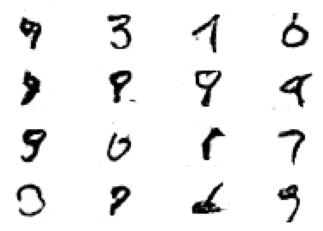

In [28]:
latent_dim = 100
n_samples = 16
z_input = generate_latent_points(latent_dim, n_samples)
# set the model PATH according to your system
model = load_model('generator_mnist.h5')
pred = model.predict(z_input)
pred = (pred +1 ) / 2.0
save_plot(pred,n=4)